In [1]:
import os
import tqdm
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

In [2]:
### READ DATA ###

df = pd.read_csv('HRSS_anomalous_optimized.csv')

print(df.shape)
df.head()

(19634, 20)


,Timestamp,Labels,I_w_BLO_Weg,O_w_BLO_power,O_w_BLO_voltage,I_w_BHL_Weg,O_w_BHL_power,O_w_BHL_voltage,I_w_BHR_Weg,O_w_BHR_power,O_w_BHR_voltage,I_w_BRU_Weg,O_w_BRU_power,O_w_BRU_voltage,I_w_HR_Weg,O_w_HR_power,O_w_HR_voltage,I_w_HL_Weg,O_w_HL_power,O_w_HL_voltage
0,0.000000,0,7.0,0.0,0.0,-547.0,0.0,0.0,-874.0,12.0,1.0,-32.0,0.0,0.0,0.0,2560.0,24.0,0.0,3434.0,24.0
1,0.043999,0,7.0,0.0,0.0,-547.0,0.0,0.0,-874.0,12.0,1.0,-32.0,0.0,0.0,0.0,2560.0,24.0,0.0,3434.0,24.0
2,0.099998,0,7.0,0.0,0.0,-547.0,0.0,0.0,-874.0,12.0,1.0,-32.0,0.0,0.0,0.0,2560.0,24.0,0.0,3434.0,24.0
3,0.143997,0,7.0,0.0,0.0,-547.0,0.0,0.0,-874.0,12.0,1.0,-32.0,0.0,0.0,0.0,2560.0,24.0,0.0,3434.0,24.0
4,0.249001,0,7.0,0.0,0.0,-547.0,0.0,0.0,-874.0,7.0,1.0,22.0,18471.0,47.0,0.0,5764.0,26.0,0.0,5008.0,24.0


In [3]:
features = ['I_w_BLO_Weg', 'O_w_BLO_power', 'O_w_BLO_voltage', 'I_w_BHL_Weg', 
            'O_w_BHL_power', 'O_w_BHL_voltage', 'I_w_BHR_Weg', 'O_w_BHR_power', 
            'O_w_BHR_voltage', 'I_w_BRU_Weg', 'O_w_BRU_power', 'O_w_BRU_voltage', 
            'I_w_HR_Weg', 'O_w_HR_power', 'O_w_HR_voltage', 'I_w_HL_Weg', 
            'O_w_HL_power', 'O_w_HL_voltage']

In [4]:
### LABEL DISTRIBUTION ###

df.Labels.value_counts()

0    15117
1     4517
Name: Labels, dtype: int64

Text(0, 0.5, 'Failure')

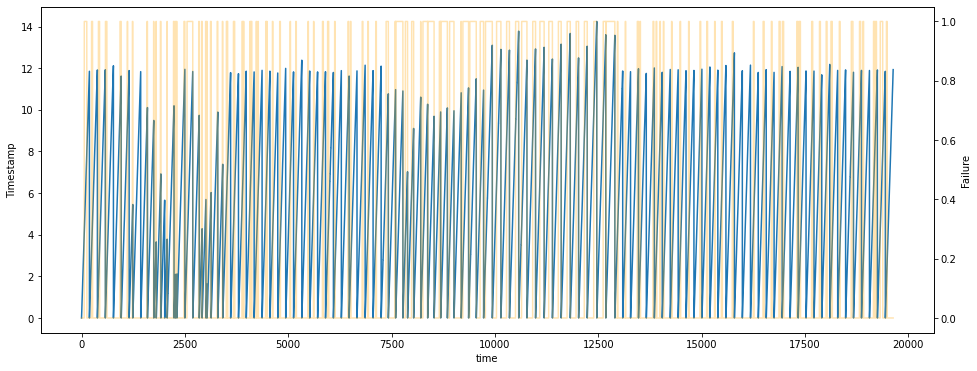

In [5]:
### CYCLE vs LABEL DISTRIBUTION ###

df.Timestamp.plot(figsize=(16,6))
plt.xlabel('time')
plt.ylabel('Timestamp')
plt.twinx()
plt.plot(df.Labels, alpha=0.3, c='orange')
plt.ylabel('Failure')

Text(0, 0.5, 'standard deviation')

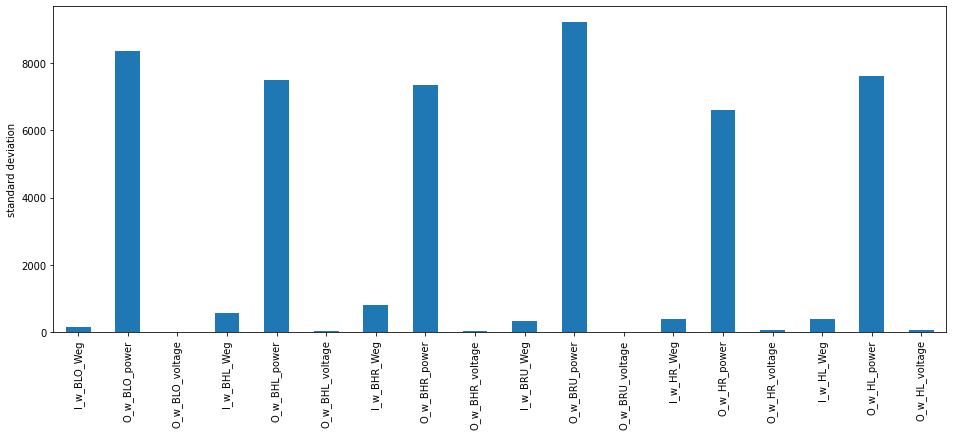

In [6]:
### SENSOR FEATURES VARIANCE ###

df.loc[:,features].std().plot.bar(figsize=(16,6))
plt.ylabel('standard deviation')

In [7]:
### UTILITY FUNCTION TO GENERATE SEQUENCE FOR LSTM ###

def gen_sequence(df, seq_length):
    
    seq_df = []
    
    for start, stop in zip(range(0, len(df)-seq_length), range(seq_length, len(df))):
        seq_df.append(df[start:stop, :])
        
    return np.asarray(seq_df)

In [8]:
### RETRIVE CYCLE NUMBER ###

k = -1
cycle = []
for i,time in df.Timestamp.iteritems(): 
    if time==0.:
        k += 1
        cycle.append(k)
    else:
        cycle.append(k)
        
df['Timestamp'] = cycle

In [9]:
### CREATE AND STANDARDIZE WINDOW SEQUENCES FOR EVERY CYCLE ###

sequence_length = 8
test_size = 0.1

X_train, X_test = [], []
Y_train, Y_test = [], []

for k,group_df in df.groupby('Timestamp'):
    
    if int(len(group_df)*test_size) > sequence_length: # at least the dimension of the test
    
        init = group_df[features].values[0] + 1e-3
        y = group_df.Labels.values
        x_train = group_df[features].values[:int(len(group_df)*(1-test_size))] / init
        x_test = group_df[features].values[int(len(group_df)*(1-test_size)):] / init

        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        x_train = gen_sequence(x_train, sequence_length)
        x_test = gen_sequence(x_test, sequence_length)
        y_train = y[sequence_length:int(len(group_df)*(1-test_size))]
        y_test = y[int(len(group_df)*(1-test_size))+sequence_length:]

        Y_train.append(y_train); Y_test.append(y_test)
        X_train.append(x_train); X_test.append(x_test)
    
    else:
        continue
    
X_train, X_test = np.vstack(X_train), np.vstack(X_test)
print(X_train.shape, X_test.shape)
Y_train, Y_test = np.concatenate(Y_train), np.concatenate(Y_test)
print(Y_train.shape, Y_test.shape)

(16445, 8, 18) (1148, 8, 18)
(16445,) (1148,)


In [10]:
### LABEL DISTRIBUTION OF TEST SET ###

pd.value_counts(Y_test)

0    710
1    438
dtype: int64

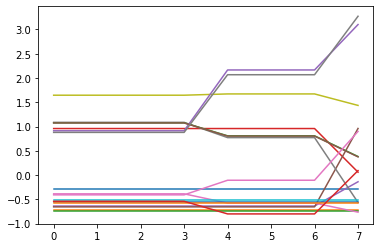

In [11]:
### PLOT EXEMPLE OF SAMPLE ###

_id_ = 39

plt.plot(X_train[_id_])
np.set_printoptions(False)

In [12]:
### GENERATE PAIR SAMPLES FOR SIAMESE NETWORK ###

os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

left_input = []
right_input = []
targets = []
pairs = 3

for i in range(len(Y_train)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i:
            compare_to = random.randint(0,len(Y_train)-1)
        left_input.append(X_train[i])
        right_input.append(X_train[compare_to])
        if Y_train[i] == Y_train[compare_to]: # They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.asarray(left_input).reshape(-1, sequence_length, len(features))
right_input = np.asarray(right_input).reshape(-1, sequence_length, len(features))
targets = np.asarray(targets)
print(left_input.shape, right_input.shape, targets.shape)

(49335, 8, 18) (49335, 8, 18) (49335,)


In [13]:
### LABEL DISTRIBUTION OF AUGMENTED DATASET ###

pd.value_counts(targets)

1.0    32570
0.0    16765
dtype: int64

In [14]:
### DEFINE SIAMESE NETWORK ARCHITECTURE ###

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def SiamesNet():
    
    set_seed(33)
    
    left_input = Input((sequence_length, len(features)))
    right_input = Input((sequence_length, len(features)))

    lstmnet = Sequential([
        BatchNormalization(),
        LSTM(128, activation='relu', return_sequences=True, 
             input_shape=(sequence_length, len(features))),
        LSTM(32, activation='relu')
    ])

    encoded_l = lstmnet(left_input)
    encoded_r = lstmnet(right_input)

    L1_layer = Lambda(lambda tensor: K.abs(tensor[0] - tensor[1]))

    L1_distance = L1_layer([encoded_l, encoded_r])
    drop = Dropout(0.2)(L1_distance)
    prediction = Dense(1,activation='sigmoid')(drop)
    model = Model(inputs=[left_input,right_input],outputs=prediction)
    
    return model

In [15]:
siamese_net = SiamesNet()
siamese_net.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-3), metrics=['accuracy'])

siamese_net.fit([left_input, right_input], targets, batch_size=512, epochs=50, 
                validation_split=0.15, verbose=2)

Epoch 1/50
82/82 - 8s - loss: 0.6425 - accuracy: 0.6541 - val_loss: 0.6287 - val_accuracy: 0.6753
Epoch 2/50
82/82 - 7s - loss: 0.6244 - accuracy: 0.6673 - val_loss: 0.6108 - val_accuracy: 0.6882
Epoch 3/50
82/82 - 9s - loss: 0.6104 - accuracy: 0.6848 - val_loss: 0.6042 - val_accuracy: 0.6954
Epoch 4/50
82/82 - 10s - loss: 0.5984 - accuracy: 0.6972 - val_loss: 0.6007 - val_accuracy: 0.6994
Epoch 5/50
82/82 - 9s - loss: 0.5889 - accuracy: 0.7080 - val_loss: 0.5924 - val_accuracy: 0.7150
Epoch 6/50
82/82 - 8s - loss: 0.5778 - accuracy: 0.7165 - val_loss: 0.5857 - val_accuracy: 0.7164
Epoch 7/50
82/82 - 8s - loss: 0.5654 - accuracy: 0.7260 - val_loss: 0.5746 - val_accuracy: 0.7199
Epoch 8/50
82/82 - 8s - loss: 0.5545 - accuracy: 0.7317 - val_loss: 0.5708 - val_accuracy: 0.7267
Epoch 9/50
82/82 - 7s - loss: 0.5408 - accuracy: 0.7454 - val_loss: 0.5683 - val_accuracy: 0.7241
Epoch 10/50
82/82 - 7s - loss: 0.5302 - accuracy: 0.7541 - val_loss: 0.5530 - val_accuracy: 0.7357
Epoch 11/50
82/82 

In [16]:
### COMPUTE PREDICTION ###

os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

real = []
pred = []
rep = 4

for j,i in enumerate(tqdm.tqdm(Y_test)):
    
    test = X_test[j]

    nofault = np.random.choice(np.where(Y_train == 0)[0], rep)
    nofault = X_train[nofault]
    nofault_sim = np.max([float(siamese_net.predict([test[np.newaxis,:,:],s[np.newaxis,:,:]])) for s in nofault])

    fault = np.random.choice(np.where(Y_train == 1)[0], rep)
    fault = X_train[fault]
    fault_sim = np.max([float(siamese_net.predict([test[np.newaxis,:,:],s[np.newaxis,:,:]])) for s in fault])
    
    pred.append('nofault' if nofault_sim > fault_sim else 'fault')
    real.append('nofault' if i == 0 else 'fault')

100%|██████████████████████████████████████████████████████████████████████████████| 1148/1148 [08:07<00:00,  2.35it/s]


In [17]:
print(classification_report(real, pred))

              precision    recall  f1-score   support

       fault       0.69      0.16      0.25       438
     nofault       0.65      0.96      0.77       710

    accuracy                           0.65      1148
   macro avg       0.67      0.56      0.51      1148
weighted avg       0.67      0.65      0.57      1148



In [18]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

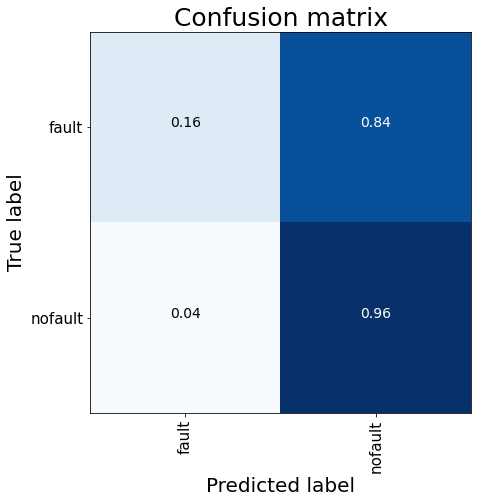

In [19]:
cnf_matrix = confusion_matrix(real, pred)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(real), title="Confusion matrix")
plt.show()

In [20]:
### DUMMY CLASSIFIER ACCURACY (always nofault) ###

sum(np.asarray(real) == 'nofault') / (sum(np.asarray(real) == 'fault') + sum(np.asarray(real) == 'nofault'))

0.6184668989547039